In [1]:
import os
os.environ['MVDB_LOG_LEVEL'] = 'ERROR'

In [2]:
from min_vec import MinVectorDB

my_db = MinVectorDB('my_vec_db')

## FLAT

In [3]:
import numpy as np
from tqdm import tqdm

# Generate vectors that need to be saved, this code is only for this demo
np.random.seed(23)
def get_test_vectors(shape):
    for i in range(shape[0]):
        yield np.random.random(shape[1])

100%|██████████| 11/11 [08:04<00:00, 44.03s/it] 


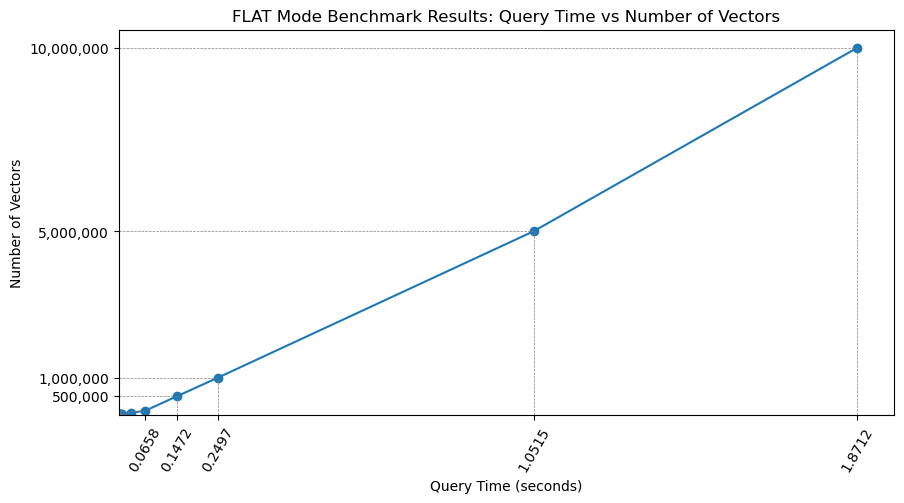

,Number of Vectors,Query Time (seconds)
0,100,0.0014
1,500,0.0015
2,1000,0.0018
3,5000,0.0042
4,10000,0.0079
5,50000,0.0310
6,100000,0.0658
7,500000,0.1472
8,1000000,0.2497
9,5000000,1.0515


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator

def benchmark_flat():
    vecs_num = []
    times = []
    for rows in tqdm([100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]):
        collection = my_db.require_collection('test_collection', dim=1024, drop_if_exists=True, index_mode='FLAT')
        with collection.insert_session():
            id = 0
            for t in get_test_vectors((rows, 1024)):
                collection.add_item(t, id=id)
                id += 1

        for _ in range(3):
            res = collection.query(np.random.random(1024), k=12)
            
        vecs_num.append(rows)
        times.append(np.round(float(collection.most_recent_query_report['Query Time'].split('s')[0]), 4))

    def thousands_formatter(x, pos):
        return '{:,.0f}'.format(x)

    def decimal_formatter(x, pos):
        return '{:.4f}'.format(x)

    plt.figure(figsize=(10, 5))
    plt.plot(times, vecs_num, 'o-')

    for (time, vec_num) in zip(times, vecs_num):
        plt.vlines(x=time, ymin=0, ymax=vec_num, colors='gray', linestyles='dashed', linewidth=0.5)
        plt.hlines(y=vec_num, xmin=0, xmax=time, colors='gray', linestyles='dashed', linewidth=0.5)

    plt.xlabel('Query Time (seconds)')
    plt.ylabel('Number of Vectors')
    plt.title('FLAT Mode Benchmark Results: Query Time vs Number of Vectors')

    y_ticks = [num for num in vecs_num if num >= 500000]
    y_tick_labels = ['{:,}'.format(num) for num in y_ticks]
    plt.yticks(y_ticks, y_tick_labels)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    # Set the x-axis to only show data points with four decimal places
    plt.gca().xaxis.set_major_locator(FixedLocator(times))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(decimal_formatter))

    plt.xticks(times[6:], rotation=60)
    
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()

    import pandas as pd
    return pd.DataFrame({'Number of Vectors': vecs_num, 'Query Time (seconds)': times})

benchmark_flat()


## IVF-FLAT

100%|██████████| 9/9 [17:34<00:00, 117.11s/it]


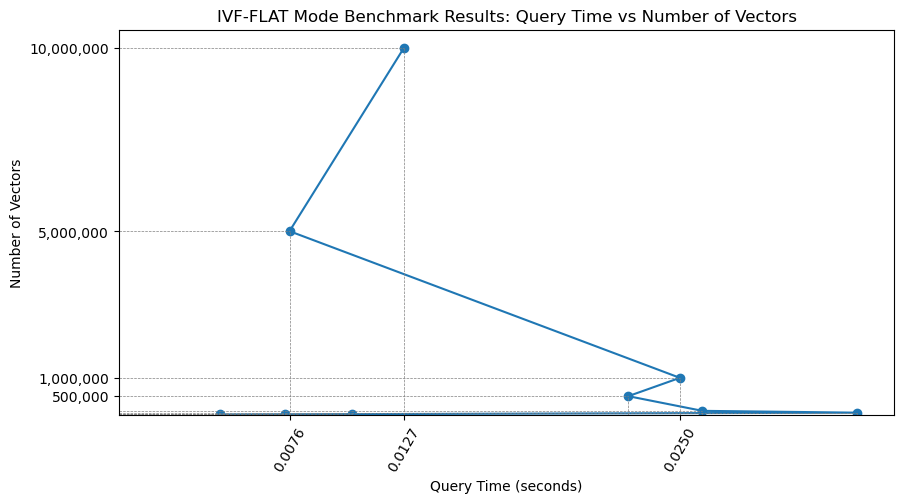

,Number of Vectors,Query Time (seconds)
0,1000,0.0045
1,5000,0.0074
2,10000,0.0104
3,50000,0.0329
4,100000,0.0260
5,500000,0.0227
6,1000000,0.0250
7,5000000,0.0076
8,10000000,0.0127


In [49]:
def benchmark_ivfflat():
    vecs_num = []
    times = []
    for rows in tqdm([1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]):
        collection = my_db.require_collection('test_collection', dim=1024, drop_if_exists=True,
                                              index_mode='IVF-FLAT', n_clusters=rows // 10000 if rows >= 100000 else 16)
        with collection.insert_session():
            # Define the initial ID.
            id = 0
            for t in get_test_vectors((rows, 1024)):
                collection.add_item(t, id=id)
                id += 1

        for _ in range(3):
            # Because of the use of jit technology, it takes one or two queries to reach normal speeds
            res = collection.query(np.random.random(1024), k=12)
            
        vecs_num.append(rows)
        times.append(np.round(float(collection.most_recent_query_report['Query Time'].split('s')[0]), 4))

    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter

    def thousands_formatter(x, pos):
        return '{:,.0f}'.format(x) 
    
    plt.figure(figsize=(10, 5))  # Set the figure size (optional)
    plt.plot(times, vecs_num, 'o-')  # Plot times on the x-axis and vecs_num on the y-axis

    for (time, vec_num) in zip(times, vecs_num):
        plt.vlines(x=time, ymin=0, ymax=vec_num, colors='gray', linestyles='dashed', linewidth=0.5)
        plt.hlines(y=vec_num, xmin=0, xmax=time, colors='gray', linestyles='dashed', linewidth=0.5)
        
    plt.xlabel('Query Time (seconds)')  # Label for the x-axis
    plt.ylabel('Number of Vectors')  # Label for the y-axis
    plt.title('IVF-FLAT Mode Benchmark Results: Query Time vs Number of Vectors')  # Title of the plot

    y_ticks = [num for num in vecs_num if num >= 500000]
    y_tick_labels = ['{:,}'.format(num) for num in y_ticks]
    plt.yticks(y_ticks, y_tick_labels)

    plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.xticks(times[6:], rotation=60)
    
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    
    plt.show()  # Show the plot

    import pandas as pd
    return pd.DataFrame({'Number of Vectors': vecs_num, 'Query Time (seconds)': times})

benchmark_ivfflat()